# Neural ODEs in NeuroMANCER  


This tutorial demonstrates the use of [Neural Ordinary Differential Equations](https://arxiv.org/abs/1806.07366) (NODE) for system identificaiton of dynamical systems. 


## System Identification Problem Setup

<img src="../figs/NODE.PNG" width="600">  


Starting from a given initial condition  $x_{0}$, the next state of the system  $x_{k+1}$
is obtained by feeding the current state $x_{k}$ into the neural network $N$ that generates a derivative to be
integrated using an integration scheme $\int$. In system identification, the loss $\mathcal{L}$ is evaluated by comparing the  trajectory generated by the model with the training trajectory. The process can be repeated for multiple trajectories to improve the generalization of the model.


### References

[1] [Ricky T. Q. Chen, Yulia Rubanova, Jesse Bettencourt, David Duvenaud, Neural Ordinary Differential Equations, NeurIPS 2018](https://arxiv.org/abs/1806.07366)  
[2] http://implicit-layers-tutorial.org/neural_odes/  
[3] https://github.com/Zymrael/awesome-neural-ode  
[4] https://rkevingibson.github.io/blog/neural-networks-as-ordinary-differential-equations/  
[5] [Christian Legaard, Thomas Schranz, Gerald Schweiger, Ján Drgoňa, Basak Falay, Cláudio Gomes, Alexandros Iosifidis, Mahdi Abkar, and Peter Larsen. 2023. Constructing Neural Network Based Models for Simulating Dynamical Systems. ACM Comput. Surv. 55, 11, Article 236 (November 2023), 34 pages.](https://dl.acm.org/doi/10.1145/3567591)



## NeuroMANCER and Dependencies

### Install (Colab only)
Skip this step when running locally.

In [ ]:
!pip install "neuromancer[examples] @ git+https://github.com/pnnl/neuromancer.git@master"

In [1]:
import torch
from neuromancer.psl import plot
from neuromancer import psl
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from neuromancer.system import Node, System
from neuromancer.dynamics import integrators, ode
from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.loggers import BasicLogger
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.modules import blocks

torch.manual_seed(0)

## Generate trajectories from ODE system 

Consider the [VanDerPol system](https://en.wikipedia.org/wiki/Van_der_Pol_oscillator) defined by the [ordinary differential equations](https://en.wikipedia.org/wiki/Ordinary_differential_equation): 

$$
 \frac{dx_1}{dt} = \mu (x_1 - \frac{1}{3}x_1^3 - x_2)   \\  
 \frac{dx_2}{dt} = \frac{x_1}{\mu} 
$$  

In this example we don't assume any prior knowledge on the system dynamics. We will only have access to limited measurements of the system states $x$.

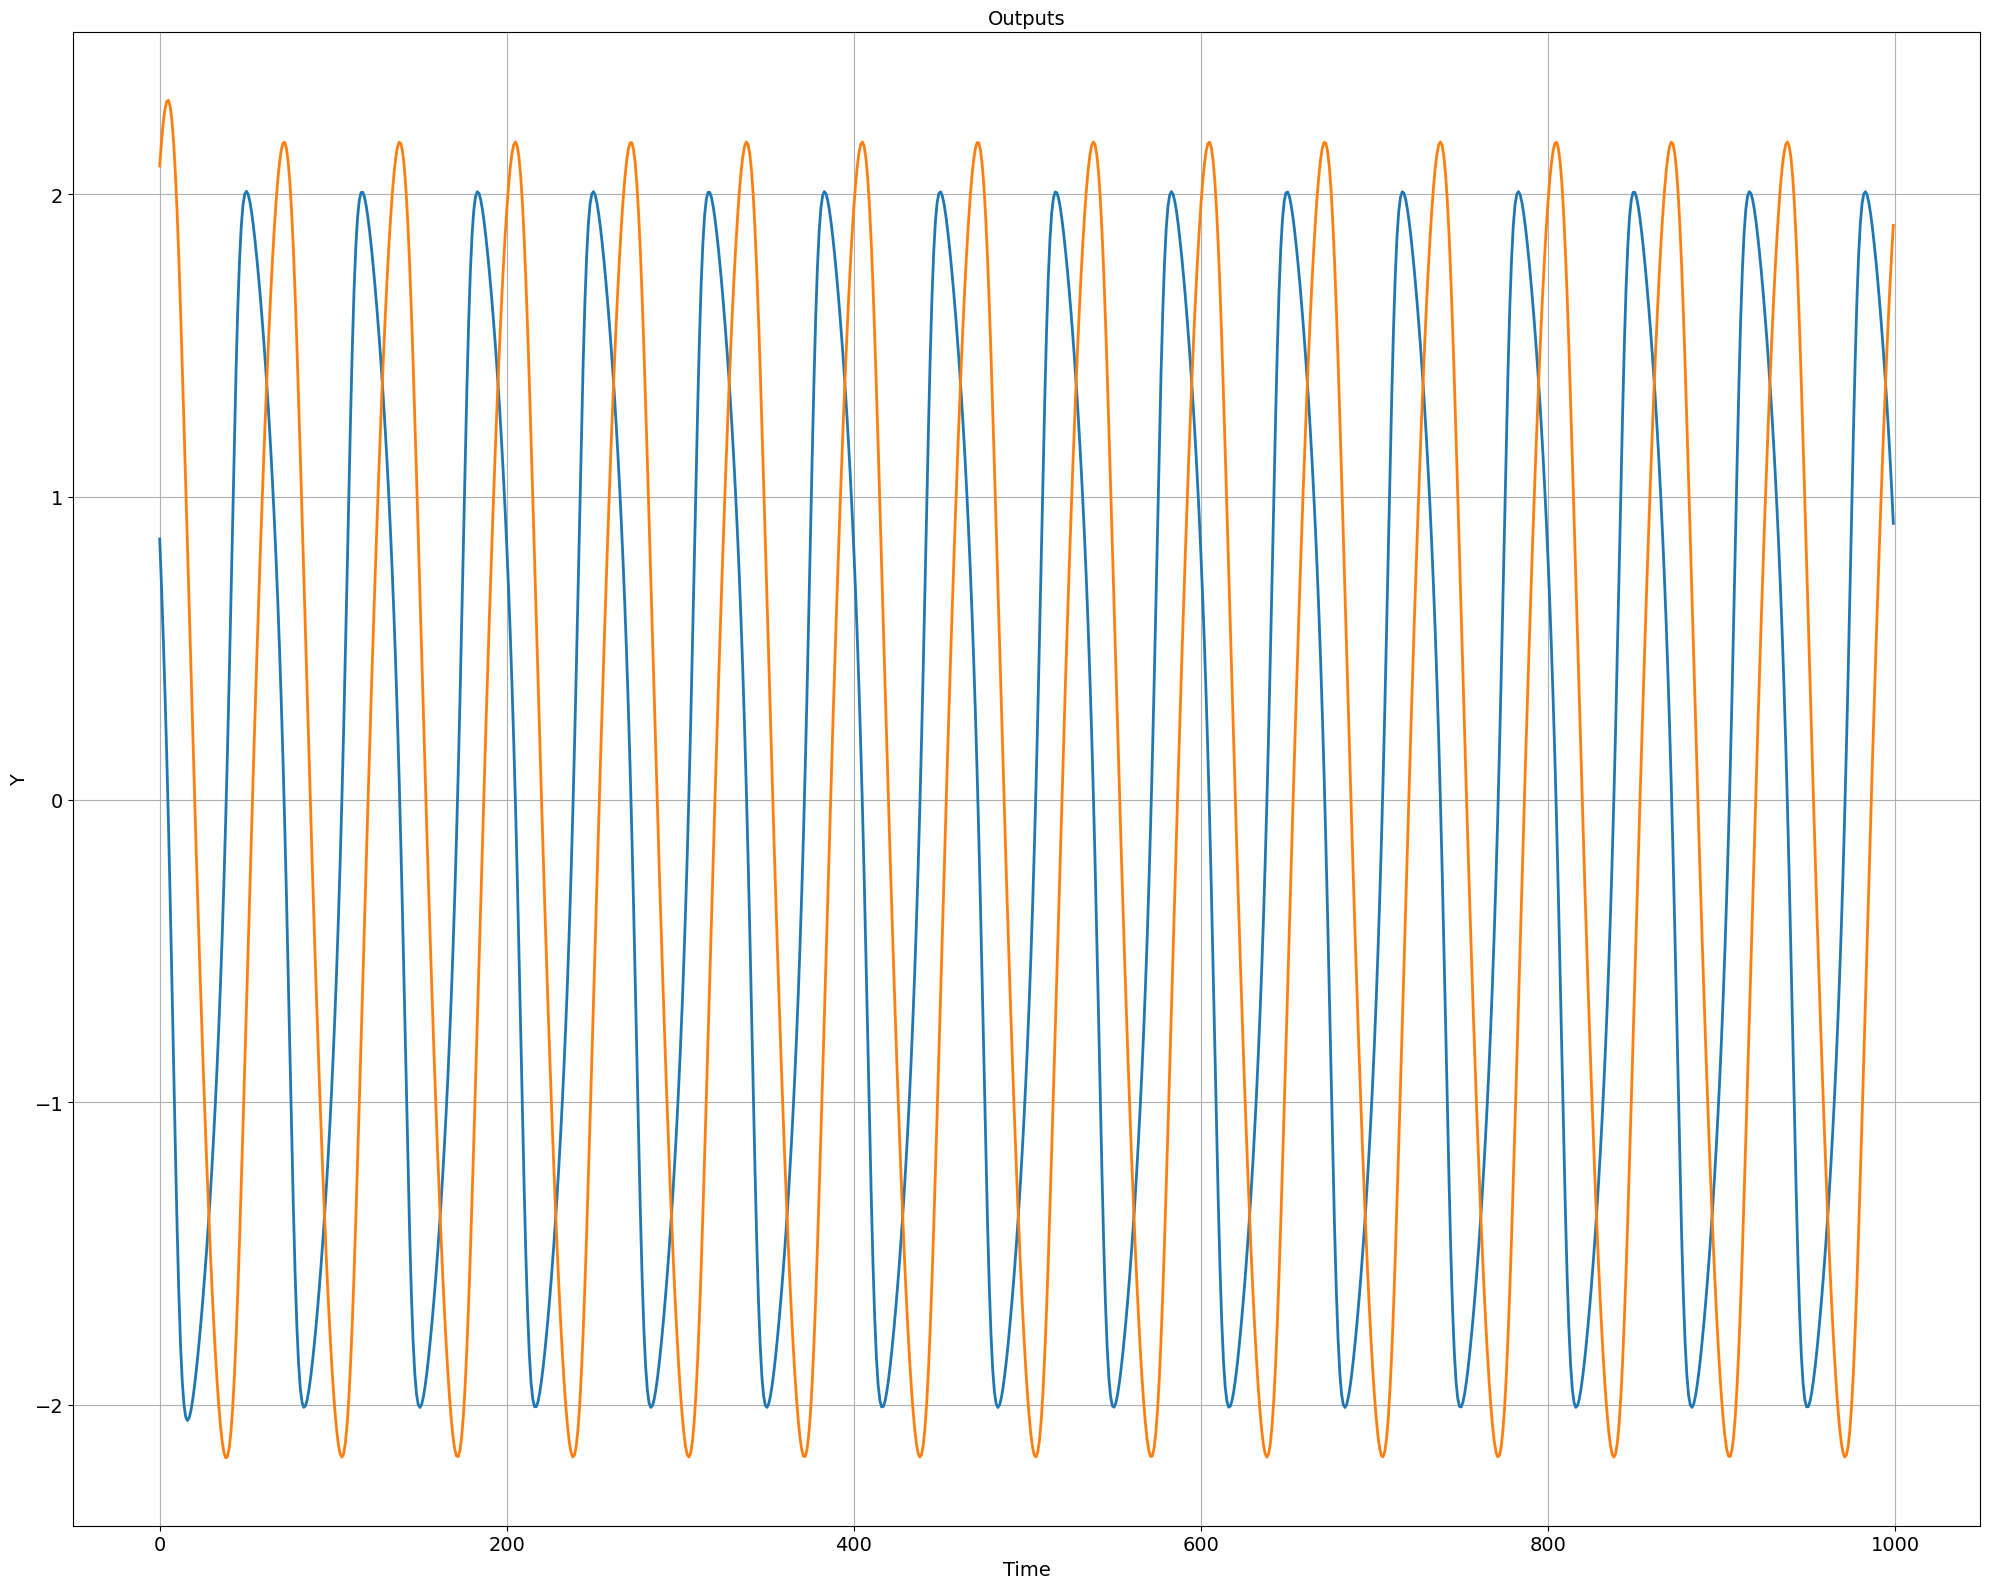

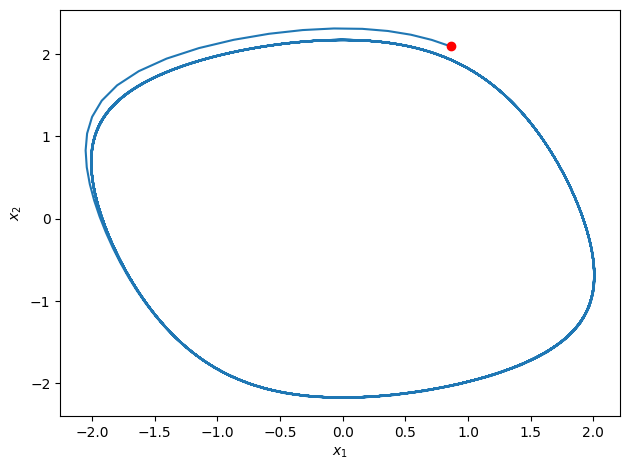

In [2]:
# %%  ground truth system
system = psl.systems['VanDerPol']
modelSystem = system()
ts = modelSystem.ts
nx = modelSystem.nx
raw = modelSystem.simulate(nsim=1000, ts=ts)
plot.pltOL(Y=raw['Y'])
plot.pltPhase(X=raw['Y'])

## Create training data of sampled trajectories

We will obtain a dataset of sampled trajectories of the system dynamics to model: 
$$\hat{X} = [\hat{x}^i_0, ..., \hat{x}^i_{N}], \, \, i \in [1, ..., m]$$
where $N$ represents the prediction horizon, $m$ represents number of measured trajectories, and $i$ represents an index of the sampled trajectory.


In [3]:
def get_data(sys, nsim, nsteps, ts, bs):
    """
    :param nsteps: (int) Number of timesteps for each batch of training data
    :param sys: (psl.system)
    :param ts: (float) step size
    :param bs: (int) batch size

    """
    train_sim, dev_sim, test_sim = [sys.simulate(nsim=nsim, ts=ts) for i in range(3)]
    nx = sys.nx
    nbatch = nsim//nsteps
    length = (nsim//nsteps) * nsteps

    trainX = train_sim['X'][:length].reshape(nbatch, nsteps, nx)
    trainX = torch.tensor(trainX, dtype=torch.float32)
    train_data = DictDataset({'X': trainX, 'xn': trainX[:, 0:1, :]}, name='train')
    train_loader = DataLoader(train_data, batch_size=bs,
                              collate_fn=train_data.collate_fn, shuffle=True)

    devX = dev_sim['X'][:length].reshape(nbatch, nsteps, nx)
    devX = torch.tensor(devX, dtype=torch.float32)
    dev_data = DictDataset({'X': devX, 'xn': devX[:, 0:1, :]}, name='dev')
    dev_loader = DataLoader(dev_data, batch_size=bs,
                            collate_fn=dev_data.collate_fn, shuffle=True)

    testX = test_sim['X'][:length].reshape(1, nsim, nx)
    testX = torch.tensor(testX, dtype=torch.float32)
    test_data = {'X': testX, 'xn': testX[:, 0:1, :]}

    return train_loader, dev_loader, test_data

In [4]:
nsim = 600   # number of simulation steps in the dataset
nsteps = 2   # number of prediction horizon steps in the loss function
bs = 100     # minibatching batch size
train_loader, dev_loader, test_data = get_data(modelSystem, nsim, nsteps, ts, bs)

## NODE system model in Neuromancer

Here we construct a continuous-time NODE model  $\dot{x} = f_{\theta}(x)$ with trainable parameters $\theta$.

In [5]:
# define neural network of the NODE
fx = blocks.MLP(nx, nx, bias=True,
                 linear_map=torch.nn.Linear,
                 nonlin=torch.nn.ReLU,
                 hsizes=[60, 60, 60])

Next we need to solve the continuous-time NODE model with suitable ODE solver, e.g., [Runge–Kutta integrator](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods).  
$x_{k+1} = \text{ODESolve}(f_{\theta}(x_k))$ 

For training we need to obtain accurate reverse-mode gradients of the integrated NODE system. This can be done in two ways, either by unrolling the operations of the ODE solver and using the [backpropagation through time](https://en.wikipedia.org/wiki/Backpropagation_through_time) (BPTT) algorithm, or via [Adjoint state method](https://en.wikipedia.org/wiki/Adjoint_state_method).

Schematics illustrating the adjoing method used in the [Neural Ordinary Differential Equations](https://arxiv.org/abs/1806.07366) paper:
<img src="../figs/NODE_backprop.png" width="500">  

Neuromancer provides a set of ODE solvers implemented in [integrators.py](https://github.com/pnnl/neuromancer/blob/master/src/neuromancer/dynamics/integrators.py).
For adjoint method we provide the interface to the [open-source implementation](https://github.com/rtqichen/torchdiffeq) via DiffEqIntegrator class.

In [6]:
# integrate NODE with adjoint-based solver
fxRK4 = integrators.DiffEqIntegrator(fx, h=ts, method='rk4')

Next we construct an open-loop system composed of a smbolic NODE model

In [7]:
# create symbolic system model in Neuromancer
model = Node(fxRK4, ['xn'], ['xn'], name='NODE')
dynamics_model = System([model], name='system', nsteps=nsteps)

In [23]:
# visualize the system
# dynamics_model.show()

## Define system identification loss function terms

Here we define loss function terms to fit the ODE parameters from given time-series data.

**Tracking loss:**  
$$\ell_x = Q_x||x^i_k - \hat{x}^i_k||_2^2$$ 
**Finite difference loss:**  
$$\ell_{dx} =  Q_{dx}||\Delta x^i_k - \Delta \hat{x}^i_k||_2^2$$
where $\Delta x^i_k = x^i_{k+1} - x^i_k$

In [8]:
# %% Constraints + losses:
x = variable("X")
xhat = variable('xn')[:, :-1, :]
# finite difference variables
xFD = (x[:, 1:, :] - x[:, :-1, :])
xhatFD = (xhat[:, 1:, :] - xhat[:, :-1, :])

# trajectory tracking loss
reference_loss = (xhat == x)^2
reference_loss.name = "ref_loss"

# finite difference loss
fd_loss = 2.*(xFD == xhatFD)^2
fd_loss.name = 'FD_loss'

## Construct System ID learning problem

Given the training dataset $\hat{X} = [\hat{x}^i_0, ..., \hat{x}^i_{N}]$ we want to solve the following problem:
 
$$
\begin{align}
&\underset{\theta}{\text{minimize}}     && \sum_{i=1}^m \Big(\sum_{k=1}^{N}  Q_x||x^i_k - \hat{x}^i_k||_2^2  +  \sum_{k=1}^{N-1}  Q_{dx}||\Delta x^i_k - \Delta \hat{x}^i_k||_2^2  \Big) \\
&\text{subject to}    && x^i_{k+1} =  \text{ODESolve}(f_{\theta}(x^i_k)) \\
\end{align}
$$  

In [9]:
# aggregate list of objective terms and constraints
objectives = [reference_loss, fd_loss]
constraints = []
# create constrained optimization loss
loss = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
problem = Problem([dynamics_model], loss)

In [26]:
# plot computational graph
# problem.show()

## Solve the problem

We fit the unknown NODE parameters $\theta$ using stochastic gradient descent.

In [10]:
optimizer = torch.optim.Adam(problem.parameters(), lr=0.001)
logger = BasicLogger(args=None, savedir='test', verbosity=1,
                     stdout=['dev_loss', 'train_loss'])
# define neuromancer trainer
trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    test_data,
    optimizer,
    patience=50,
    warmup=100,
    epochs=500,
    eval_metric="dev_loss",
    train_metric="train_loss",
    dev_metric="dev_loss",
    test_metric="dev_loss",
    logger=logger,
)

# %% train
best_model = trainer.train()
problem.load_state_dict(best_model)

None
Number of parameters: 7622
epoch: 0	train_loss: 0.04616	dev_loss: 0.04439	eltime:  0.16038
epoch: 1	train_loss: 0.04229	dev_loss: 0.04218	eltime:  0.21043
epoch: 2	train_loss: 0.04167	dev_loss: 0.04180	eltime:  0.29876
epoch: 3	train_loss: 0.03413	dev_loss: 0.03351	eltime:  0.35262
epoch: 4	train_loss: 0.03059	dev_loss: 0.02892	eltime:  0.40529
epoch: 5	train_loss: 0.02564	dev_loss: 0.02503	eltime:  0.46167
epoch: 6	train_loss: 0.02355	dev_loss: 0.02029	eltime:  0.50992
epoch: 7	train_loss: 0.01770	dev_loss: 0.01689	eltime:  0.55860
epoch: 8	train_loss: 0.01419	dev_loss: 0.01275	eltime:  0.61264
epoch: 9	train_loss: 0.00927	dev_loss: 0.00872	eltime:  0.66223
epoch: 10	train_loss: 0.00631	dev_loss: 0.00595	eltime:  0.71307
epoch: 11	train_loss: 0.00430	dev_loss: 0.00368	eltime:  0.76417
epoch: 12	train_loss: 0.00309	dev_loss: 0.00285	eltime:  0.80996
epoch: 13	train_loss: 0.00317	dev_loss: 0.00305	eltime:  0.85653
epoch: 14	train_loss: 0.00260	dev_loss: 0.00232	eltime:  0.90060
epo

<All keys matched successfully>

In [42]:
from torch.utils.data import Dataset, DataLoader
import lightning.pytorch as pl 
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping


checkpoint_callback = ModelCheckpoint(
    monitor='train_loss',
    mode='min',
    save_top_k=1,
    dirpath='./foo',
    save_weights_only=True,
    filename='best_model-{epoch:02d}-{val_loss:.2f}'
)

early_stopping_callback = EarlyStopping(monitor='train_loss', patience=50)

class LitProblem(pl.LightningModule): 
    def __init__(self, problem, train_metric, dev_metric): 
        super().__init__()
        self.problem = problem 
        self.train_metric = train_metric
        self.dev_metric = dev_metric
        self.training_step_outputs = []
    
    def training_step(self, batch): 
        output = self.problem(batch)
        loss = output[self.train_metric]
        self.training_step_outputs.append(loss)
        self.log('train_loss', loss, on_epoch=True, enable_graph=True, prog_bar=False)
        return loss 
    
    def on_train_epoch_end(self):
        epoch_average = torch.stack(self.training_step_outputs).mean()
        print("EPOCH AVERAGE ", epoch_average)
        self.log("training_epoch_average", epoch_average)
        self.training_step_outputs.clear()  # free memory

    
    def validation_step(self, batch): 
        output = self.problem(batch)
        loss = output[self.dev_metric]
        self.log('val_loss', loss)
    
    def configure_optimizers(self): 
        optimizer = torch.optim.Adam(problem.parameters(), 0.001, betas=(0.0, 0.9))
        return optimizer 
    

class LightningDataModule(pl.LightningDataModule): 
    def __init__(self,data_setup_function, batch_size, *args, **kwargs): 
        super().__init__()
        self.data_setup_function = data_setup_function
        self.batch_size = batch_size 
        self.data_setup_args = args
        self.data_setup_kwargs = kwargs

    def setup(self, stage=None): 
        train_data, dev_data,test_data = self.data_setup_function(*self.data_setup_args, **self.data_setup_kwargs)

        self.train_data = train_data
        self.test_data = test_data
        self.dev_data = dev_data
 
    def train_dataloader(self): 
        return DataLoader(self.train_data, batch_size=self.batch_size, collate_fn=self.train_data.collate_fn)
    
    def dev_dataloader(self): 
        return DataLoader(self.dev_data, batch_size=self.batch_size, collate_fn=self.dev_data.collate_fn)

    def test_dataloader(self): 
        return DataLoader(self.test_data, batch_size=self.batch_size, collate_fn=self.test_data.collate_fn)

def data_setup_function(sys, nsim, nsteps, ts, bs):
    """
    :param nsteps: (int) Number of timesteps for each batch of training data
    :param sys: (psl.system)
    :param ts: (float) step size
    :param bs: (int) batch size

    """
    train_sim, dev_sim, test_sim = [sys.simulate(nsim=nsim, ts=ts) for i in range(3)]
    nx = sys.nx
    nbatch = nsim//nsteps
    length = (nsim//nsteps) * nsteps

    trainX = train_sim['X'][:length].reshape(nbatch, nsteps, nx)
    trainX = torch.tensor(trainX, dtype=torch.float32)
    train_data = DictDataset({'X': trainX, 'xn': trainX[:, 0:1, :]}, name='train')


    devX = dev_sim['X'][:length].reshape(nbatch, nsteps, nx)
    devX = torch.tensor(devX, dtype=torch.float32)
    dev_data = DictDataset({'X': devX, 'xn': devX[:, 0:1, :]}, name='dev')
    

    testX = test_sim['X'][:length].reshape(1, nsim, nx)
    testX = torch.tensor(testX, dtype=torch.float32)
    test_data = {'X': testX, 'xn': testX[:, 0:1, :]}

    return train_data, dev_data, test_data


In [48]:
mymodel = LitProblem(problem, train_metric='train_loss', dev_metric='train_loss')
data_module = LightningDataModule(data_setup_function, 64, modelSystem, nsim, nsteps, ts, bs)
trainer = pl.Trainer(max_epochs=50, num_sanity_val_steps=0, callbacks=[early_stopping_callback, checkpoint_callback])
trainer.fit(mymodel, data_module)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/birm560/opt/anaconda3/envs/neuromancer/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/Users/birm560/opt/anaconda3/envs/neuromancer/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:630: Checkpoint directory /Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/examples/ODEs/foo exists and is not empty.

  | Name    | Type    | Params
------------------------------------
0 | problem | Problem | 7.6 K 
------------------------------------
7.6 K     Trainable params
0         Non-trainable params
7.6 K     Total params
0.030     Total estimated model params size (MB)
/Users/birm560/opt/anaconda3/envs/neuromancer/lib/python3.10/site-packages/lightning/pytorch/trai

Epoch 9: 100%|██████████| 5/5 [00:00<00:00, 46.24it/s, v_num=13]


In [50]:
best_weights_path = checkpoint_callback.best_model_path
print(best_weights_path)
# Load the best weights using the model class
best_model = mymodel.load_from_checkpoint(best_weights_path)








/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/examples/ODEs/foo/best_model-epoch=09-val_loss=0.00.ckpt


TypeError: The classmethod `LitProblem.load_from_checkpoint` cannot be called on an instance. Please call it on the class type and make sure the return value is used.

## Parameter estimation results

In [29]:
# update the rollout length based on the test data
dynamics_model.nsteps = test_data['X'].shape[1]

In [30]:
# Test set results
test_outputs = dynamics_model(test_data)

pred_traj = test_outputs['xn'][:, :-1, :]
true_traj = test_data['X']
pred_traj = pred_traj.detach().numpy().reshape(-1, nx)
true_traj = true_traj.detach().numpy().reshape(-1, nx)
pred_traj, true_traj = pred_traj.transpose(1, 0), true_traj.transpose(1, 0)

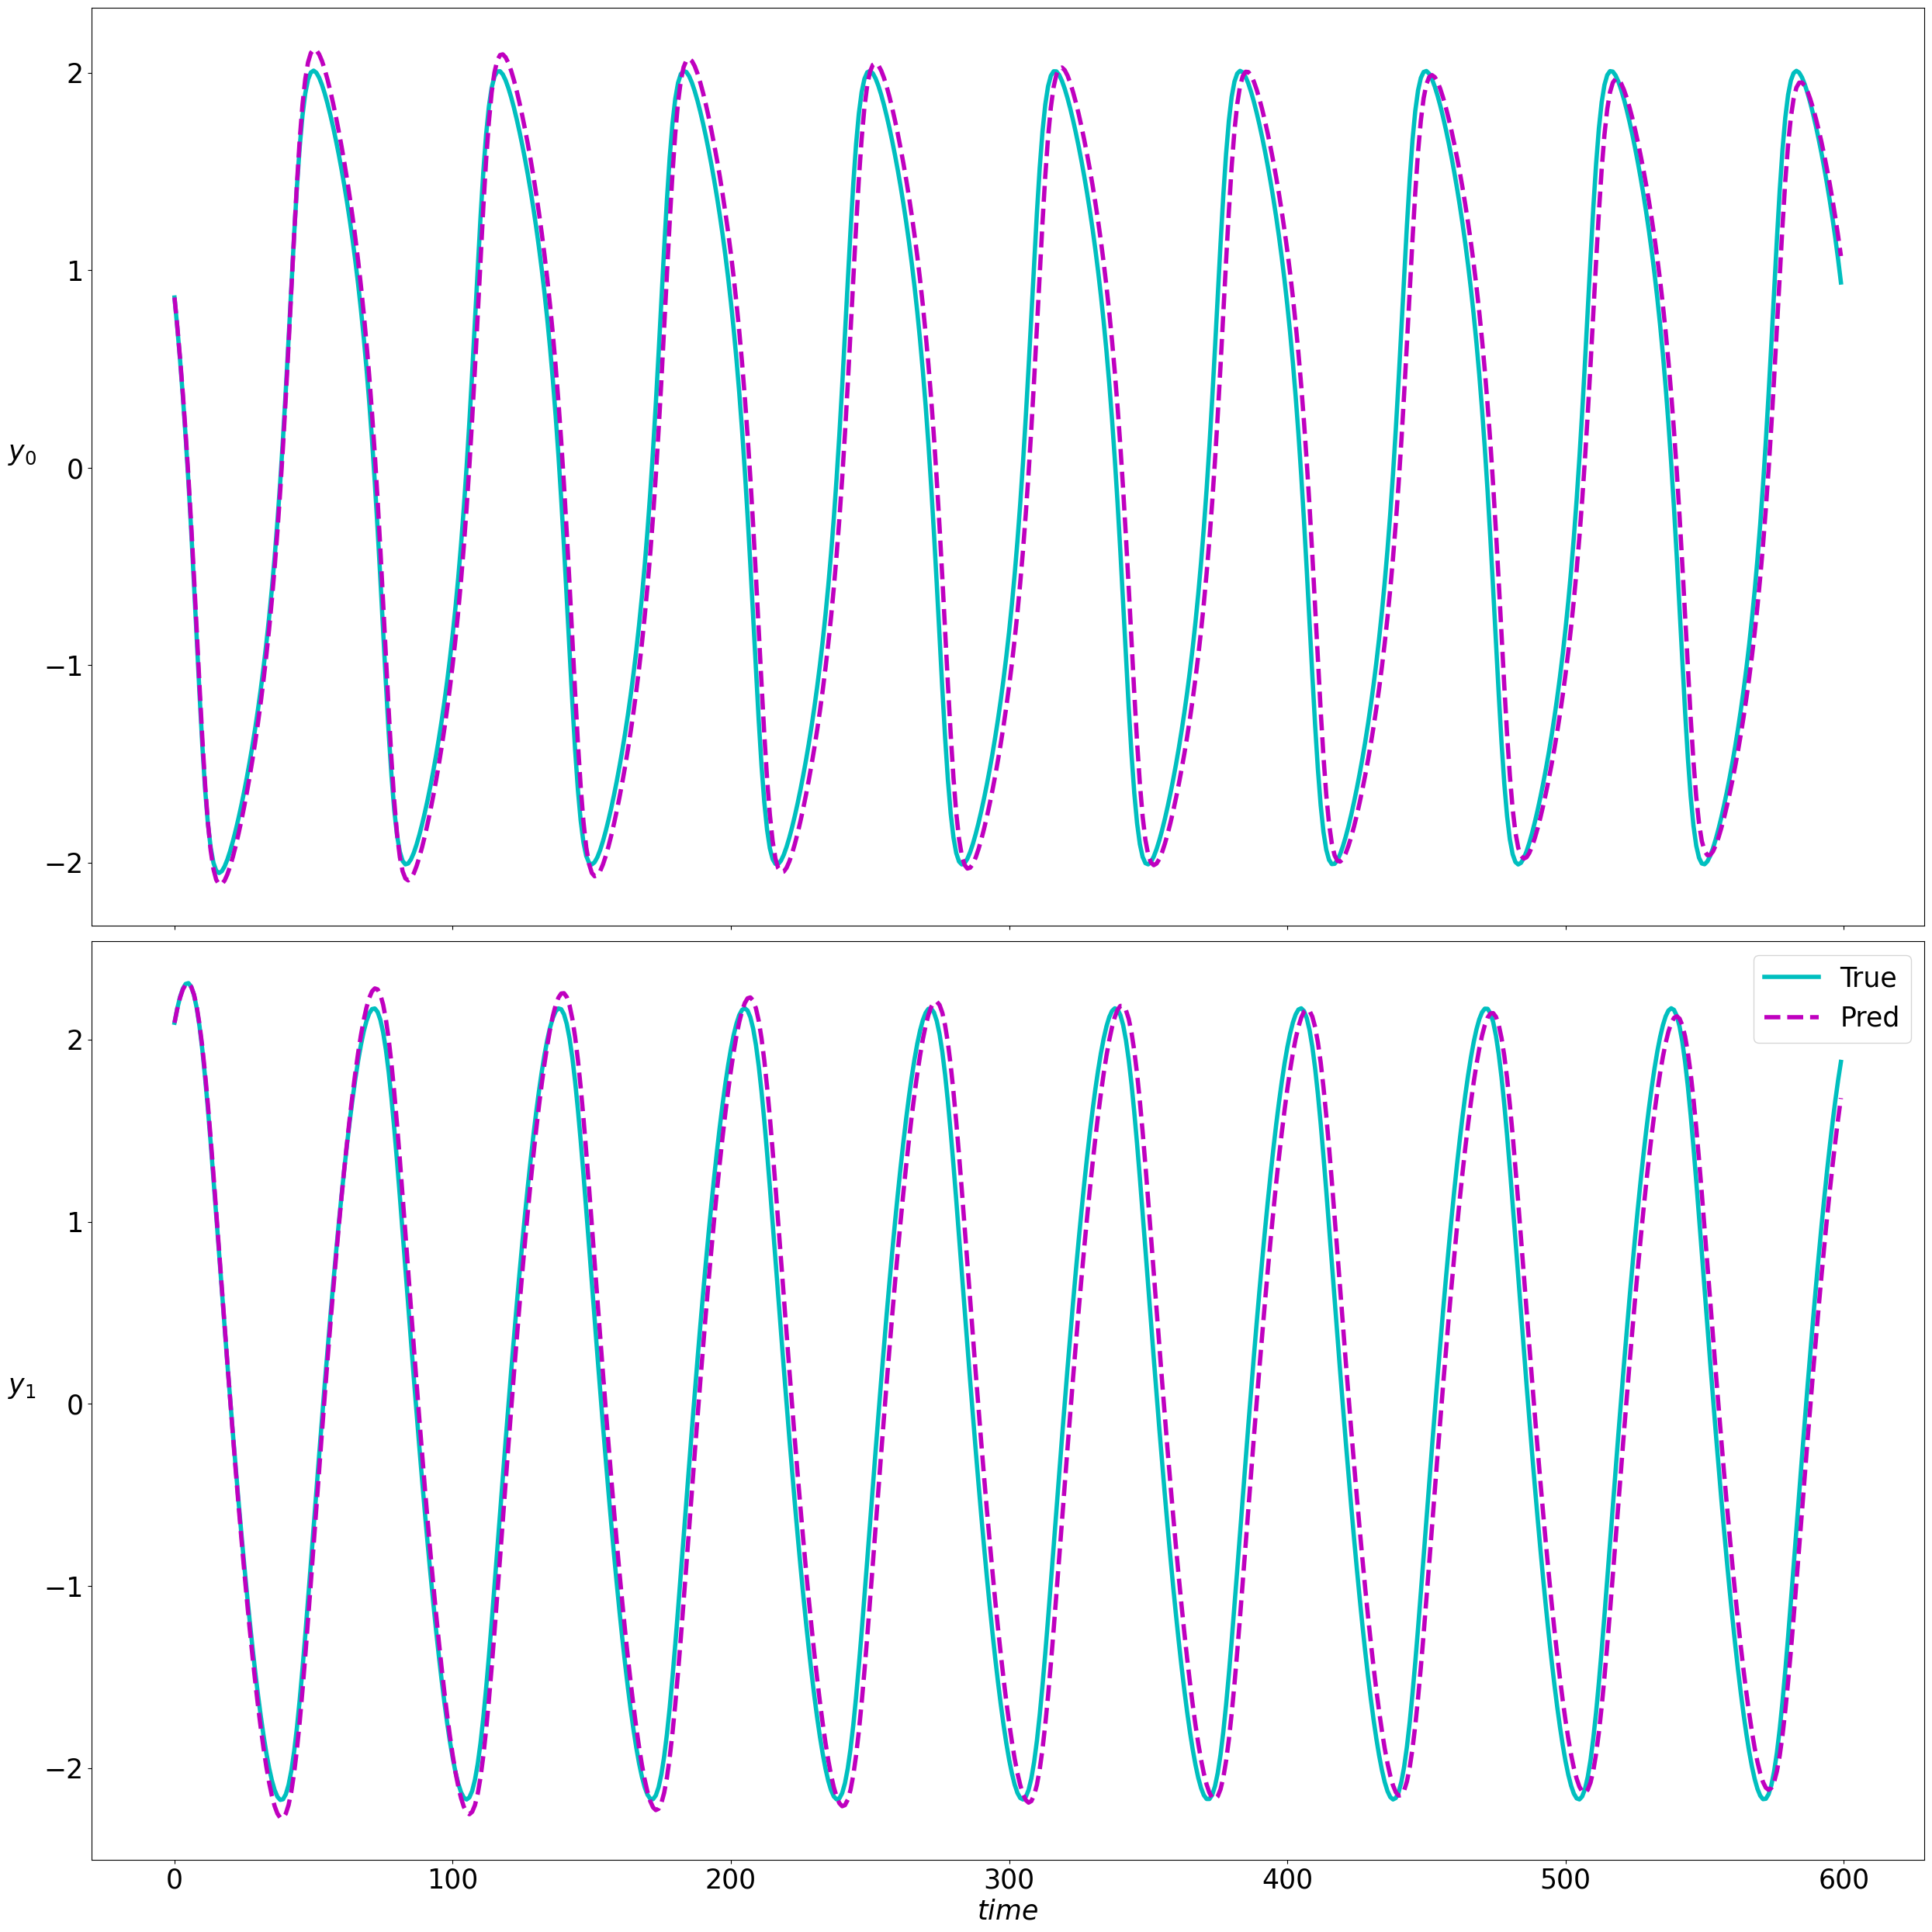

In [31]:
# plot rollout
figsize = 25
fig, ax = plt.subplots(nx, figsize=(figsize, figsize))
labels = [f'$y_{k}$' for k in range(len(true_traj))]
for row, (t1, t2, label) in enumerate(zip(true_traj, pred_traj, labels)):
    if nx > 1:
        axe = ax[row]
    else:
        axe = ax
    axe.set_ylabel(label, rotation=0, labelpad=20, fontsize=figsize)
    axe.plot(t1, 'c', linewidth=4.0, label='True')
    axe.plot(t2, 'm--', linewidth=4.0, label='Pred')
    axe.tick_params(labelbottom=False, labelsize=figsize)
axe.tick_params(labelbottom=True, labelsize=figsize)
axe.legend(fontsize=figsize)
axe.set_xlabel('$time$', fontsize=figsize)
plt.tight_layout()